# Sharks attack

## 1.- Data cleaning

           

Let's begin importing the libraries necesary to conduct this project.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re

The csv file with all the shark attack information is located in the shark-attack folder of the repo. We load the data using Pandas

In [2]:
sharks = pd.read_csv("../shark-attack/attacks.csv", index_col=0, encoding = "ISO-8859-1") #encoding = "utf-8"

Now let's see how the database is organized using .head() and .info(). This will allow us to decide how to prepare the data cleaning process.

In [3]:
sharks.head()

,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
Case Number,,,,,,,,,,,,,,,,,,,,,
2018.06.25,25-Jun-2018,2018.0,Boating,USA,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,57,...,White shark,"R. Collier, GSAF",2018.06.25-Wolfe.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.25,2018.06.25,6303.0,NaN,NaN
2018.06.18,18-Jun-2018,2018.0,Unprovoked,USA,Georgia,"St. Simon Island, Glynn County",Standing,Adyson McNeely,F,11,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.18-McNeely.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.18,2018.06.18,6302.0,NaN,NaN
2018.06.09,09-Jun-2018,2018.0,Invalid,USA,Hawaii,"Habush, Oahu",Surfing,John Denges,M,48,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.09-Denges.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.09,2018.06.09,6301.0,NaN,NaN
2018.06.08,08-Jun-2018,2018.0,Unprovoked,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,male,M,NaN,...,2 m shark,"B. Myatt, GSAF",2018.06.08-Arrawarra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.08,2018.06.08,6300.0,NaN,NaN
2018.06.04,04-Jun-2018,2018.0,Provoked,MEXICO,Colima,La Ticla,Free diving,Gustavo Ramos,M,NaN,...,"Tiger shark, 3m",A .Kipper,2018.06.04-Ramos.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.04,2018.06.04,6299.0,NaN,NaN


In [4]:
sharks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25723 entries, 2018.06.25 to xx
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    6302 non-null   object 
 1   Year                    6300 non-null   float64
 2   Type                    6298 non-null   object 
 3   Country                 6252 non-null   object 
 4   Area                    5847 non-null   object 
 5   Location                5762 non-null   object 
 6   Activity                5758 non-null   object 
 7   Name                    6092 non-null   object 
 8   Sex                     5737 non-null   object 
 9   Age                     3471 non-null   object 
 10  Injury                  6274 non-null   object 
 11  Fatal (Y/N)             5763 non-null   object 
 12  Time                    2948 non-null   object 
 13  Species                 3464 non-null   object 
 14  Investigator or Source  6285 non-null

1.- Having a look at the column names, We will rename three of them, as for two of them ("Sex ", "Species ") there is an extra space at the end of the column name. The other, "Fatal (Y/N)", we will rename it as just "Fatal".

In [5]:
sharks.columns

Index(['Date', 'Year', 'Type', 'Country', 'Area', 'Location', 'Activity',
       'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time', 'Species ',
       'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22',
       'Unnamed: 23'],
      dtype='object')

In [6]:
sharks=sharks.rename(columns={"Sex ": "Sex", "Species ": "Species", "Fatal (Y/N)": "Fatal"})

2.- Now we will drop the colums with almost all values NaN, that are 'Unnamed: 22' and 'Unnamed: 23'

In [7]:
sharks=sharks.drop(columns=['Unnamed: 22', 'Unnamed: 23'])

3.- There are as well columns with almost exact information ('Case Number.1'/'Case Number.2' and  'href formula'/'href'). So we eliminate one of each pair and rename the remaining one. 

In [8]:
sharks=sharks.rename(columns={"Case Number.1": "Case Number", "href ": "link"})
sharks=sharks.drop(columns=['href formula', 'Case Number.2'])

4.- From the date column, we extract the information of the month (the year is in another table, and we are not going to work with the exact day of the year). To do so, we use regex to find the month information in each column. For a fraction of them, this information is not available, so we mark them with "Unk" (unknown). 

The information with NaN is marked afterwards with "Unk" as well to fill these points in the dataframe.

In [9]:
def find_month(string):
    months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    try:
        for month in months:
            if re.search(month,string):
                return month
    except TypeError:
        pass

sharks['Month'] = sharks['Date']    
sharks['Month'] = sharks['Date'].apply(find_month)
sharks['Month'].fillna(value="Unk",inplace=True)

5.- Now we are going to clean the "Type" column, so we group all boat related incidents in the "Boating" category. We also gropup all "Questionable" and "Invalid" categories into "Unknown", as well as the NaN data.

In [10]:
sharks["Type"].unique()

array(['Boating', 'Unprovoked', 'Invalid', 'Provoked', 'Questionable',
       'Sea Disaster', nan, 'Boat', 'Boatomg'], dtype=object)

In [11]:
sharks['Type'].fillna("Unknown",inplace=True)
sharks['Type'] = sharks['Type'].apply(lambda x: "Boating" if x == "Boat" else x)
sharks['Type'] = sharks['Type'].apply(lambda x: "Boating" if x == "Boatomg" else x)
sharks['Type'] = sharks['Type'].apply(lambda x: "Unknown" if x == "Questionable" else x)
sharks['Type'] = sharks['Type'].apply(lambda x: "Unknown" if x == "Invalid" else x) 

6.- Now we reformat the information about the gender information in the database, as there are son extra spaces and wrong inputs.

In [12]:
sharks["Sex"].unique()

array(['F', 'M', nan, 'M ', 'lli', 'N', '.'], dtype=object)

In [13]:
sharks['Sex'].fillna("UNKNOWN",inplace=True) 
sharks['Sex'] = sharks['Sex'].apply(lambda x: "M" if x == "M " else x)
#The rest of them as I checked I prefer to group them in the UNKNOWN category
sharks['Sex'] = sharks['Sex'].apply(lambda x: "UNKNOWN" if x == "N" else x)
sharks['Sex'] = sharks['Sex'].apply(lambda x: "UNKNOWN" if x == "lli" else x)
sharks['Sex'] = sharks['Sex'].apply(lambda x: "UNKNOWN" if x == "." else x)

7.- In the case of the "Fatal" column, we rename some values to group them in the same category. There are two inputs that, looking at the other columns, they are non fatal, so we mark them like thar. The NaN rows are filled with "UNKNOWN" values

In [14]:
sharks["Fatal"].unique()

array(['N', 'Y', nan, 'M', 'UNKNOWN', '2017', ' N', 'N ', 'y'],
      dtype=object)

In [15]:
sharks['Fatal'].fillna("UNKNOWN",inplace=True) 
sharks['Fatal'] = sharks['Fatal'].apply(lambda x: "N" if x == " N" else x)
sharks['Fatal'] = sharks['Fatal'].apply(lambda x: "Y" if x == "y" else x)
#As they were only a few, I checked them
sharks['Fatal'] = sharks['Fatal'].apply(lambda x: "N" if x == "M" else x)
sharks['Fatal'] = sharks['Fatal'].apply(lambda x: "N" if x == "2017" else x)


8.- In order to clean the country information, we are going to put homogeneity in the data by capitalizing all the inputs. We mark as "UNKNOWN" when a cell is between two countries, as we don't know with precision the country. The same applies when there is a question mark. We also group the "COAST OF AFRICA" values as "AFRICA". Lastly, all NaN are marked as "UNKNOWN".

In [16]:
sharks['Country'].fillna("UNKNOWN",inplace=True) 
sharks['Country'] = sharks['Country'].apply(lambda x: x.upper())
sharks['Country'] = sharks['Country'].apply(lambda x: "UNKNOWN" if ("/" in list(x)) else x)
sharks['Country'] = sharks['Country'].apply(lambda x: "UNKNOWN" if ("?" in list(x)) else x)
sharks['Country'] = sharks['Country'].apply(lambda x: "AFRICA" if x=="COAST OF AFRICA" else x)

9.- For the rest of columns (except the "Species" column, that we are going to treat in the following section), we fill NaN values with "Unknown".

In [17]:
sharks['Investigator or Source'].fillna("Unknown",inplace=True)
sharks['Area'].fillna("Unknown",inplace=True) 
sharks['Location'].fillna("Unknown",inplace=True) 
sharks['Time'].fillna("Unknown",inplace=True) 
sharks['Name'].fillna("Unknown",inplace=True) 
sharks['Age'].fillna("Unknown",inplace=True) 


10.- Lastly, we are going to clean the "Species" columns. With the help of regex, we are going to replace the string of the description with the name of the species, if available. If not, we are going to mark it with "Unknown", just as the NaN values. In addition, there are inputs that shows that some events are not related with sharks attacks, or it i not confirmed, so we are going to lable them as "Questionable". 

In [18]:
def clean_species(string):
    species = ["wobbegong","tiger","bull","grey","nurse","cookiecutter","spinner","white","sandtiger",
               "eeef","bronze whaler","galapagos","blacktip","hammerhead","mako","blue","salmon","porbeagle",
               "raggedtooth","zambesi","whitetip","lemon","thresher","sandtiger","spurdog","reef"
               ,"bronze whale","seven-gill","sevengill","angel","goblin","sandbar","copper","whaler"
               ,"dusky","leopard","sand","zambezi","silky","whale","dog","blackfin","albimarginatus"
               ,"carpet","broadnose","bonita","scyliorhinus canicula","cow","cookie cutter","smoothhound"
               ,"basking","catsharks","hooked","carcharhinid","gaffed","silvertip"]

    doubts = ["hoax","not confirmed","invalid incident","questionable","not a shark","doubtful"
            "no shark","not cofirmed","unconfired","unconfirmed","could not be determined","stunt"]    
    
    for shark in species:
        if re.search(shark,string.lower()):
            return shark.capitalize()
        
    for doubt in doubts:
        if re.search(doubt,string.lower()):
            return "Questionable"

    return "Unknown"

sharks['Species'].fillna("Unknown",inplace=True) 
sharks['Species'] = sharks['Species'].apply(clean_species)

As the questionable rows are only a few, we can drop them off the database without biasing our analysis, so we can obtain more reliable results.

In [19]:
sharks[sharks['Species'] == "Questionable"].shape

(386, 20)

In [20]:
sharks=sharks[sharks['Species'] != "Questionable"]

# 2.- Visualization

Now we are going to visualize the cleaned results in order to begin with the analysis.

First, we plot the year distribution of the shark attack inputs. We choose different bins and different year ranges for a better visualization.

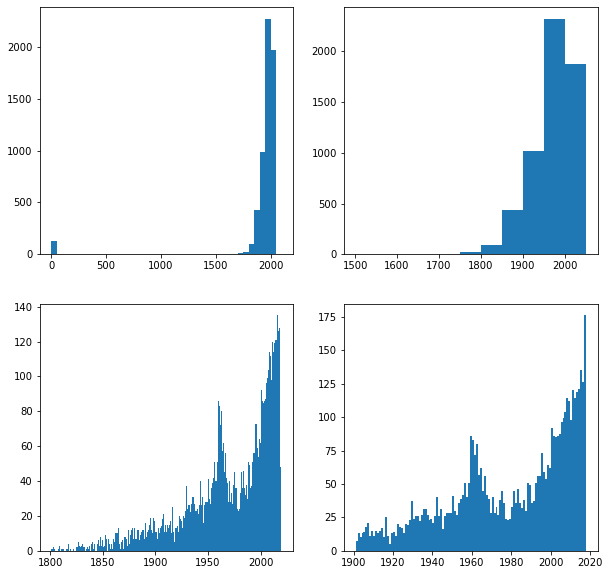

In [21]:
plt.figure(figsize=(10,10))
plt.subplot( 2,2, 1)
bins_y=np.arange(0, 2051 + 50, 50)
plt.hist(sharks["Year"],bins=bins_y)
plt.subplot( 2,2, 2)
bins_y=np.arange(1501, 2051 + 50, 50)
plt.hist(sharks["Year"],bins=bins_y)
plt.subplot( 2,2, 3)
bins_y=np.arange(1801, 2021)
plt.hist(sharks["Year"],bins=bins_y)
plt.subplot( 2,2, 4)
bins_y=np.arange(1901, 2019)
plt.hist(sharks["Year"],bins=bins_y)
plt.show()

There is a spike of sharks attack roughly in the year ~1960. At this time, it was subject of a scientific paper due to a rapid increase.

https://science.sciencemag.org/content/134/3472/87

Nevertheles, the overall trend besides this spike, is an uniform increment of the reoprting of shark related incidents. The majority of the reports are from the XIX, XX centuries and the ones of the XXI until 2018 (528, 3341 and 1878, respectively). This might be explained to more capacity of gathering information with time.

We are going to work only with the ones from the XIX-XXI centirues, in order to work with more reliable information. Just in case, we are going to save the different centuries info in different dataframes in case we are going to analyse time trends

In [22]:
sharks19 =sharks[(sharks["Year"] >=1801) & (sharks["Year"] < 1901)]
sharks20 =sharks[(sharks["Year"] >=1901) & (sharks["Year"] < 2001)]
sharks21 =sharks[sharks["Year"] >=2001]
sharks =sharks[sharks["Year"] >=1801]

In [23]:
sharks19.shape

(528, 20)

In [24]:
sharks20.shape

(3341, 20)

In [25]:
sharks21.shape

(1878, 20)

The distributions of the type of incidents is shown in the figure just below. The vast majority of the shark attaks are unprovoked (4442), followed by provoked incidents (565), sailing related (337) and disasters (228). There are only 175 events without proper identifiction. 

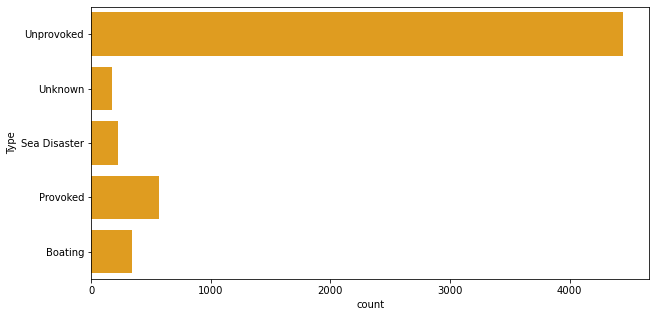

In [26]:
plt.figure(figsize=(10,5))
types = sharks["Type"].dropna().sort_values(ascending=False).unique()
sns.countplot(y=(sharks["Type"]),color="orange",order=types)
plt.show()

In [27]:
sharks["Type"].value_counts()

Unprovoked      4442
Provoked         565
Boating          337
Sea Disaster     228
Unknown          175
Name: Type, dtype: int64

Now we are going to plot the fatal events in relation with the type of incident. The ones with higher fatal rate are the sea disasters, followed by the unprovoked incidents. The rest of the incidents are not normally fatal, even the proviked ones.

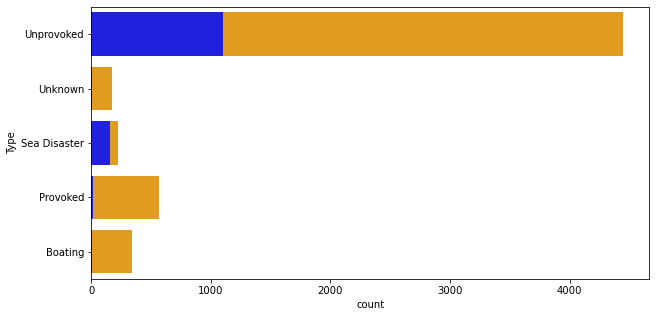

In [28]:
plt.figure(figsize=(10,5))
sns.countplot(y="Type", data=sharks,color="orange",order=types)
sns.countplot(y="Type", data=sharks[sharks["Fatal"] == "Y"],color="blue",order=types)
plt.show()

There is a clearly skewed gender distribution of the attacks. The vast majority of the people involved in sharks attacks are men.

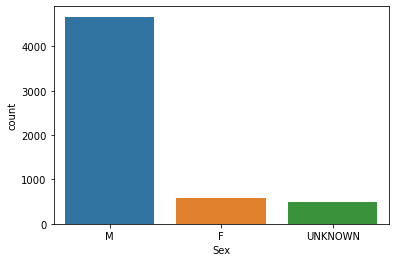

In [29]:
sns.countplot(x="Sex", data=sharks,order=["M","F","UNKNOWN"])
plt.show()

The distribution of attacks through the year is not the same, as they are more frequent in summer.

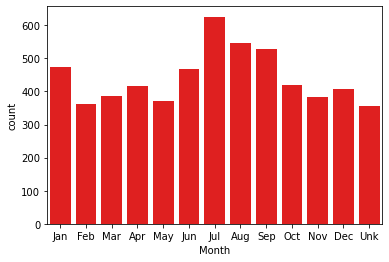

In [30]:
order_months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec","Unk"]
sns.countplot(x="Month", data=sharks,color="red",order=order_months)
plt.show()

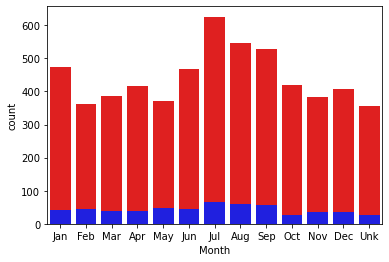

In [31]:
sns.countplot(x="Month", data=sharks,color="red", order=order_months)
sns.countplot(x="Month", data=sharks[sharks["Type"] == "Provoked"],color="Blue", order=order_months)
plt.show()

The countries where the shark attacks are more commin are the United States, Australia and South Africa, in that order. For the rest of the countries there are reported rougly 100 caser or less. Below we represent the top-10 countries

In [32]:
countries = sharks["Country"].value_counts().sort_values(ascending=False)
countries[:10]

USA                 2060
AUSTRALIA           1237
SOUTH AFRICA         522
PAPUA NEW GUINEA     128
NEW ZEALAND          120
BRAZIL               104
BAHAMAS              104
MEXICO                83
FIJI                  61
ITALY                 60
Name: Country, dtype: int64

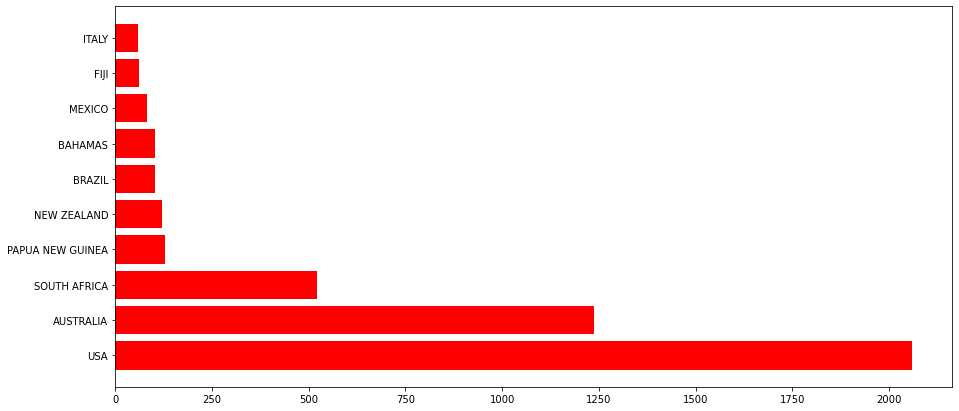

In [33]:
plt.figure(figsize=(15,7))
plt.barh(countries[0:10].index,countries[0:10].values, color="red")
plt.show()

For almost all of the shark attacks, we do not have species information. Among the fraction that we know which species are involved, the most common are the white, tiger and bull sharks. The rest of the species have less than 100 incidents for each one.

In [34]:
species = sharks["Species"].value_counts().sort_values(ascending=False)
species[:11]

Unknown          3851
White             658
Tiger             280
Bull              172
Blacktip           74
Grey               64
Bronze whaler      63
Nurse              55
Mako               54
Blue               53
Wobbegong          50
Name: Species, dtype: int64

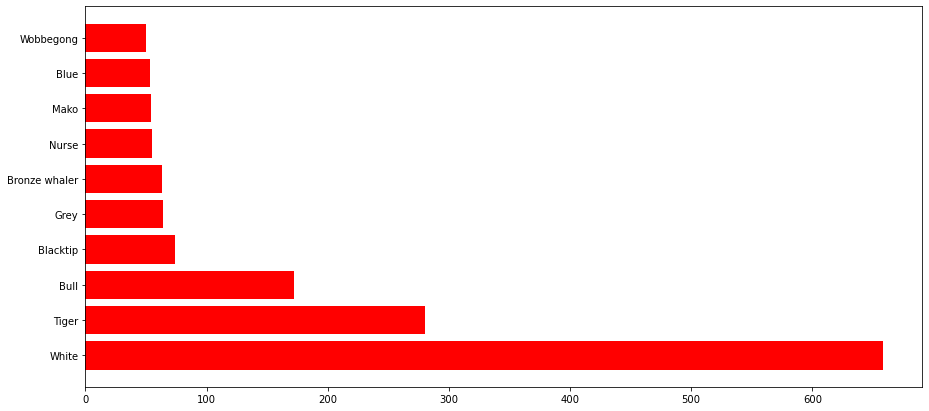

In [35]:
plt.figure(figsize=(15,7))
plt.barh(species[1:11].index,species[1:11].values, color="red")
plt.show()

## 3.- Word frequency based analysis of the database

There are strings with information about each incident and the injuries related. The database is long enough to be hard to obtain broad information about what happend in the incidents.

My approach to the analysis is if, using the word frequency of the information listed in the database, we can learn about the nature of the shark attacks of each type category. 

To do so we create functions to obtain a dictionary of the word frequency of an input. We exclude common words (a,the,in...) to obtain the words that are going to help through the analysis. We also exclude some words that might not be informative in this case (as shark, water or sea)

In [36]:
def word_count(df):
    counts = dict()
    common = ["the","in","a","&","for","to","of","on","shark","it","were","out",
              "at","by","water","from","into","/","his","her","he","she","men","as",
             "after","with","was","when","off","sea","and","or","but","down","sharks",
             "him","her","shark's","that","an","went","days","day","3","2","1"]
    
    for string in df: 
        try:
            words = string.replace(",","").replace(".","").replace(";","").split()
        except AttributeError:
            pass

        for word in words:
            if word.lower() in common:
                pass
            elif word.lower() in counts:
                counts[word.lower()] += 1
            else:
                counts[word.lower()] = 1

    return counts

def word_count_injuries(df):
    counts = dict()
    common = ["the","in","a","&","for","to","of","on","shark","it","were","out","boat","as",
              "at","by","water","from","into","/","his","her","he","she","men","board","m","some",
             "after","with","was","when","off","sea","and","or","but","down","sharks","have",
             "him","her","shark's","that","an","went","days","day","3","2","1","no","not"]
    
    for string in df: 
        try:
            words = string.replace(",","").replace('"',"").replace(".","").replace(";","").split()
        except AttributeError:
            pass

        for word in words:
            if word.lower() in common:
                pass
            elif word.lower() in counts:
                counts[word.lower()] += 1
            else:
                counts[word.lower()] = 1

    return counts

Now let's compute the word frequency of the sharks attack "Activity" column to measure and convert it to a Pandas series variable.

In [37]:
dic = word_count(sharks["Activity"])

activity_words = pd.Series( dic )

By sorting the frequency and obtaining the most repated words in the activity record, we obtain that the most common word is surfing, followed by swiming. In third position is fishing. 

The majority of the word are related with water activities (surfing, swimming, diving,...) and followed by fishing (fishing, spearfishing,...). These are the activities that are mosly related by shark incidents. There are other words related with sailing (boat, boarding,...) in the top 20 words.

In [38]:
activity_words=activity_words.sort_values(ascending=False)
activity_words[:20]

surfing         1129
swimming        1095
fishing          757
diving           525
spearfishing     435
bathing          200
wading           173
standing         158
scuba            141
boat             136
body             136
boarding         131
snorkeling       103
free              99
overboard         98
fell              96
fish              62
capsized          60
floating          54
ship              54
dtype: int64

To better visualize the results below we show a plot of the word frequency.

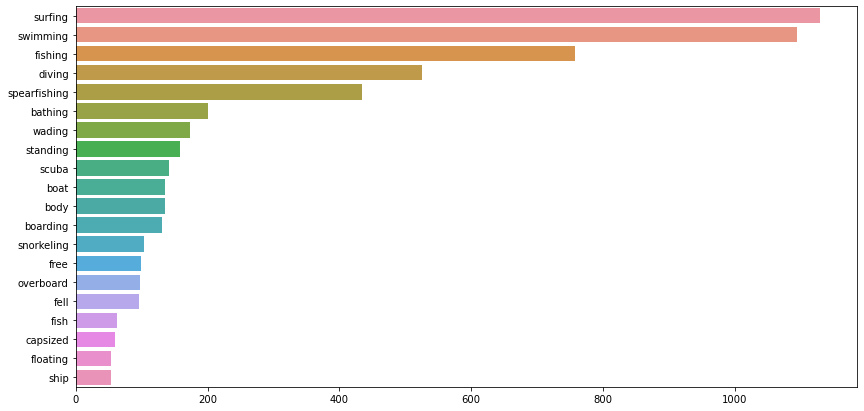

In [39]:
f, ax = plt.subplots(figsize=(14, 7))
sns.barplot(x=activity_words[:20] ,y=activity_words[:20].index)
plt.show()

Now we are going to do the same exercise dividing the word frequency analysis in different type of attacks:

- Unprovoked: As they are the vast majority of the cases, it is very similar to the overall data, but with less relative frequency of fishing related words.
- Unknown: The most frequent words are swimming, diving, spearfishing, surfing and fishing, as the main population but with different relative frequencies.
- Sea Disaster: These are more related to boat sanks and war events.
- Provoked: The most frequent words are related to fishing rather than vandalism as the name of the type could suggest.
- Boating: As in the prevous category, the most frequent word is fishing.

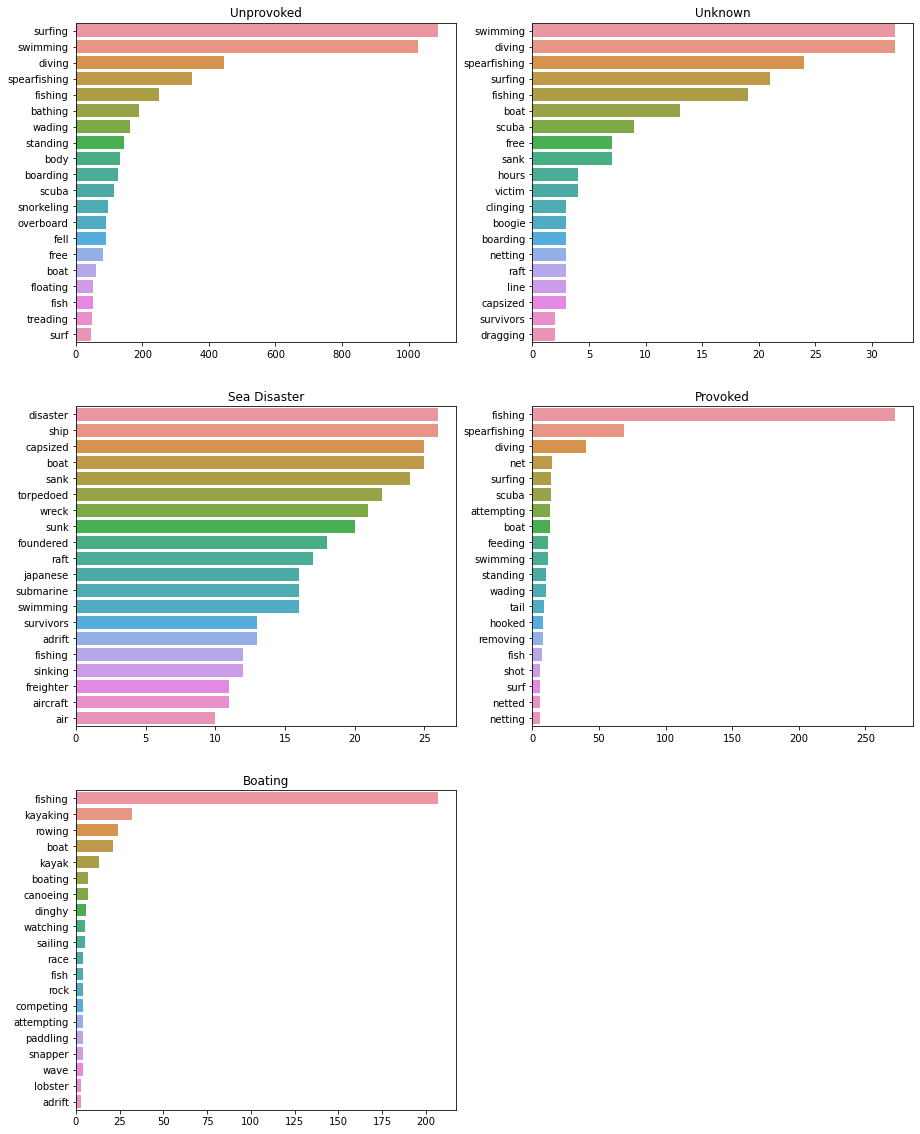

In [40]:
plt.figure(figsize=(15,20))
for i in range(len(types)):
    plt.subplot( len(types)//2+1,len(types)//2, i+1)
    plt.title(types[i])
    dic = word_count(sharks[sharks["Type"] == types[i]]["Activity"])
    injury_words = pd.Series( dic ).sort_values(ascending=False)
    sns.barplot(x=injury_words[:20] ,y=injury_words[:20].index)
plt.show()

The word frequency of the injuries report may be less informative as the activity one, but here are a few highlights of the analysis:

- In "Unprovoked" and "Sea Disaster" the word fatal appears more than in the rest. These are the categories that show more fatality ratio, so just having the word frequency we could have a hint of this information.
- In the "Unknown" category, among the most frequent words there are words as post-mortem, found, body, reported,.. that indicates that the origin of the shark incident is not clear because in many cases it may be reported afterwards the attack.
- In the "Sea Disaster" category, it is more often talked about survivors, crew, etc.


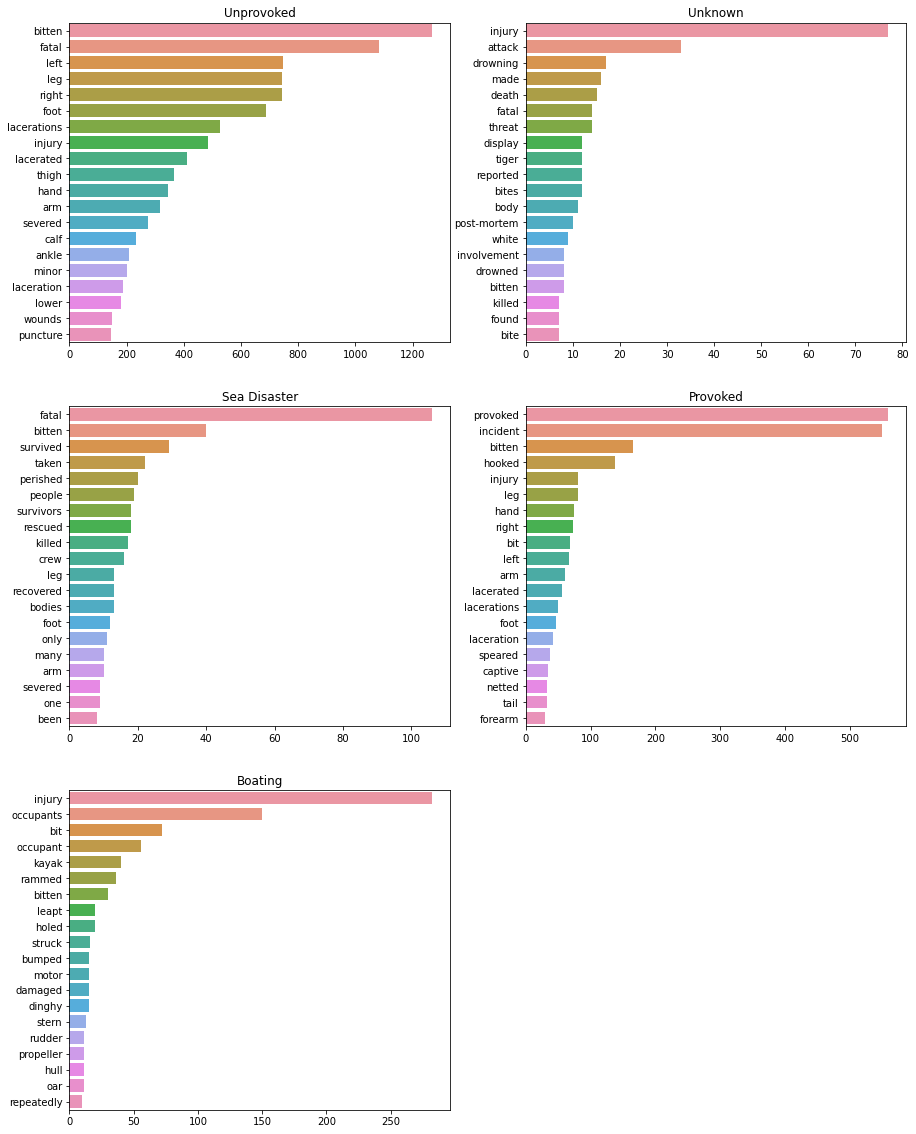

In [41]:
plt.figure(figsize=(15,20))
for i in range(len(types)):
    plt.subplot( len(types)//2+1,len(types)//2, i+1)
    plt.title(types[i])
    dic = word_count_injuries(sharks[sharks["Type"] == types[i]]["Injury"])
    injury_words = pd.Series( dic ).sort_values(ascending=False)
    sns.barplot(x=injury_words[:20] ,y=injury_words[:20].index)
plt.show()